In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

## Литература
* 

In [2]:
A = np.random.rand(5, 2)
b = np.random.rand(5)

Result = namedtuple('Result', ('x', 'fun', 'grad'))

In [5]:
class NNLS:
    def __init__(self, A, b):
        self.A = np.asarray(A)
        self.b = np.asarray(b)
        self._x = np.zeros(A.shape[1])
        self.P = np.zeros_like(self._x, dtype=bool)
        self.w = np.empty_like(self._x)
        self.recalc_w = True
        self.t = None
    
    def loss(self, x):
        return np.linalg.norm(self.A @ x - self.b)**2
    
    def result(self):
        return Result(self.x, self.loss(self.x), self.w)
    
    @staticmethod
    def argmax_index(x, idx):
        i = np.argmax(x[idx])
        return np.arange(x.size)[idx][i]
    
    def solve(self):
        if self.recalc_w:
            self.w[:] = self.negative_grad(self.x)
        # -------------------v
        if np.all(self.w <= 1e-8) or np.all(self.P):
        # -------------------^
            return self.result()
        self.t = self.argmax_index(self.w, self.Z)
        self.P[self.t] = True
        self.inner_solve()
        return self.solve()

    def inner_solve(self):
        z = np.zeros_like(self.x)
        z[self.P] = np.linalg.lstsq(self.A[:, self.P], self.b)[0]
        if z[self.t] <= 0:
            self.w[self.t] = 0
            self.recalc_w = False
            return
        else:
            self.recalc_w = True
        if np.all(z[self.P] > 0):
            self.x = z
            return
        i_z_nonpos = (z <= 0) & self.P
        alpha = np.min(self.x[i_z_nonpos] / (self.x[i_z_nonpos] - z[i_z_nonpos]))
        self.x = self.x + alpha * (z - self.x)
        self.inner_solve()
    
    def negative_grad(self, x):
        return self.A.T @ (self.b - self.A @ x)
    
    @property
    def x(self):
        return self._x
    
    @x.setter
    def x(self, v):
        self._x[:] = v
        self._x[self._x <= 0] = 0
        self.P[self._x == 0] = False
    
    @property
    def Z(self):
        return ~self.P

In [6]:
print(A)
print(b)
print('##############', np.linalg.lstsq(A, b)[0])
n = NNLS(A, b)
print(n.solve())

[[0.57656513 0.98940921]
 [0.09357157 0.56663701]
 [0.2432718  0.90527938]
 [0.89113221 0.8630906 ]
 [0.83112185 0.6651435 ]]
[0.06130424 0.3911546  0.19115644 0.02317265 0.52650439]
############## [0.07718428 0.19909836]
Result(x=array([0.07718428, 0.19909836]), fun=0.26216803846882375, grad=array([-2.22044605e-16, -1.66533454e-16]))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


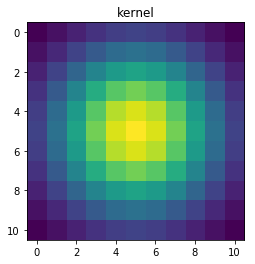

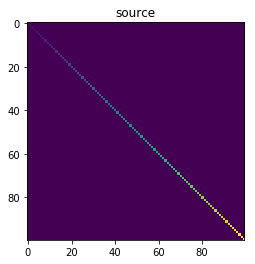

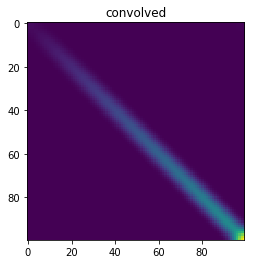

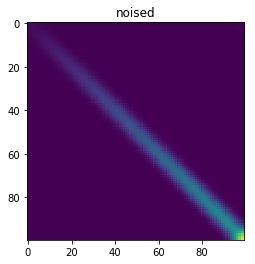

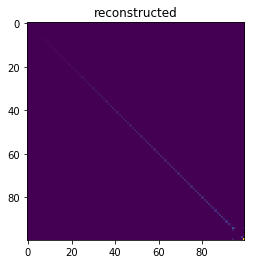

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import convolve


def show_img(array, title=''):
    plt.figure()
    plt.title(title)
    plt.imshow(array)


kernel_size = 11
sigma = 3
x, y = np.indices((kernel_size, kernel_size)) - kernel_size // 2
kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
show_img(kernel, 'kernel')
source = np.zeros((100, 100))
source[np.diag_indices(source.shape[0])] = np.arange(source.shape[0]) + 2
source[0, -1] = 3
# source = np.array(Image.open('casa.png'), dtype=np.float)[::2, ::2]
show_img(source, 'source')
convolved = convolve(source, kernel)
show_img(convolved, 'convolved')
noised = convolved + 2 - 4 * np.random.rand(*source.shape)
show_img(noised, 'noised')
a = np.zeros(convolved.shape + source.shape)
for convolved_idx in np.ndindex(convolved.shape):
    for kernel_idx in np.ndindex(kernel.shape):
        k_idx = tuple(x - size // 2 for size, x in zip(kernel.shape, kernel_idx))
        source_idx = tuple(x + y for x, y in zip(convolved_idx, k_idx))
        if ((source_idx[0] < 0)
            or (source_idx[1] < 0)
            or (source_idx[0] >= source.shape[0])
            or (source_idx[1] >= source.shape[1])):
            continue
        a[convolved_idx + source_idx] = kernel[kernel_idx]
a = a.reshape(convolved.size, source.size)
# print(a)
b = convolved.reshape(-1)
n = NNLS(a, b)
result = n.solve()
# print(result.x.reshape(source.shape))
show_img(result.x.reshape(source.shape), 'reconstructed')